In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from tinycp.regressor import ConformalizedRegressor
from tinycp.plot import plot_prediction_intervals


In [2]:
df = pd.read_csv("./data/cancer_reg.csv", encoding='iso-8859-1')

In [3]:
def corr_heatmap(df, width=1600, height=1600, fig_type=None):
    """   
    Generate a correlation heatmap for the DataFrame.
    """
    fig = px.imshow(df.corr(numeric_only=True), text_auto=True, aspect="equal", color_continuous_scale='RdBu_r', title='Heatmap of Correlation Coefficients')
    fig.update_layout(width=width, height=height)
    return fig.show(fig_type)

# EDA

In [4]:
df = df[df['MedianAge'] <= 90]

In [5]:
#df = pd.get_dummies(df, columns=['binnedInc'], dtype=int) # Explode. One-hot encoding for binnedInc

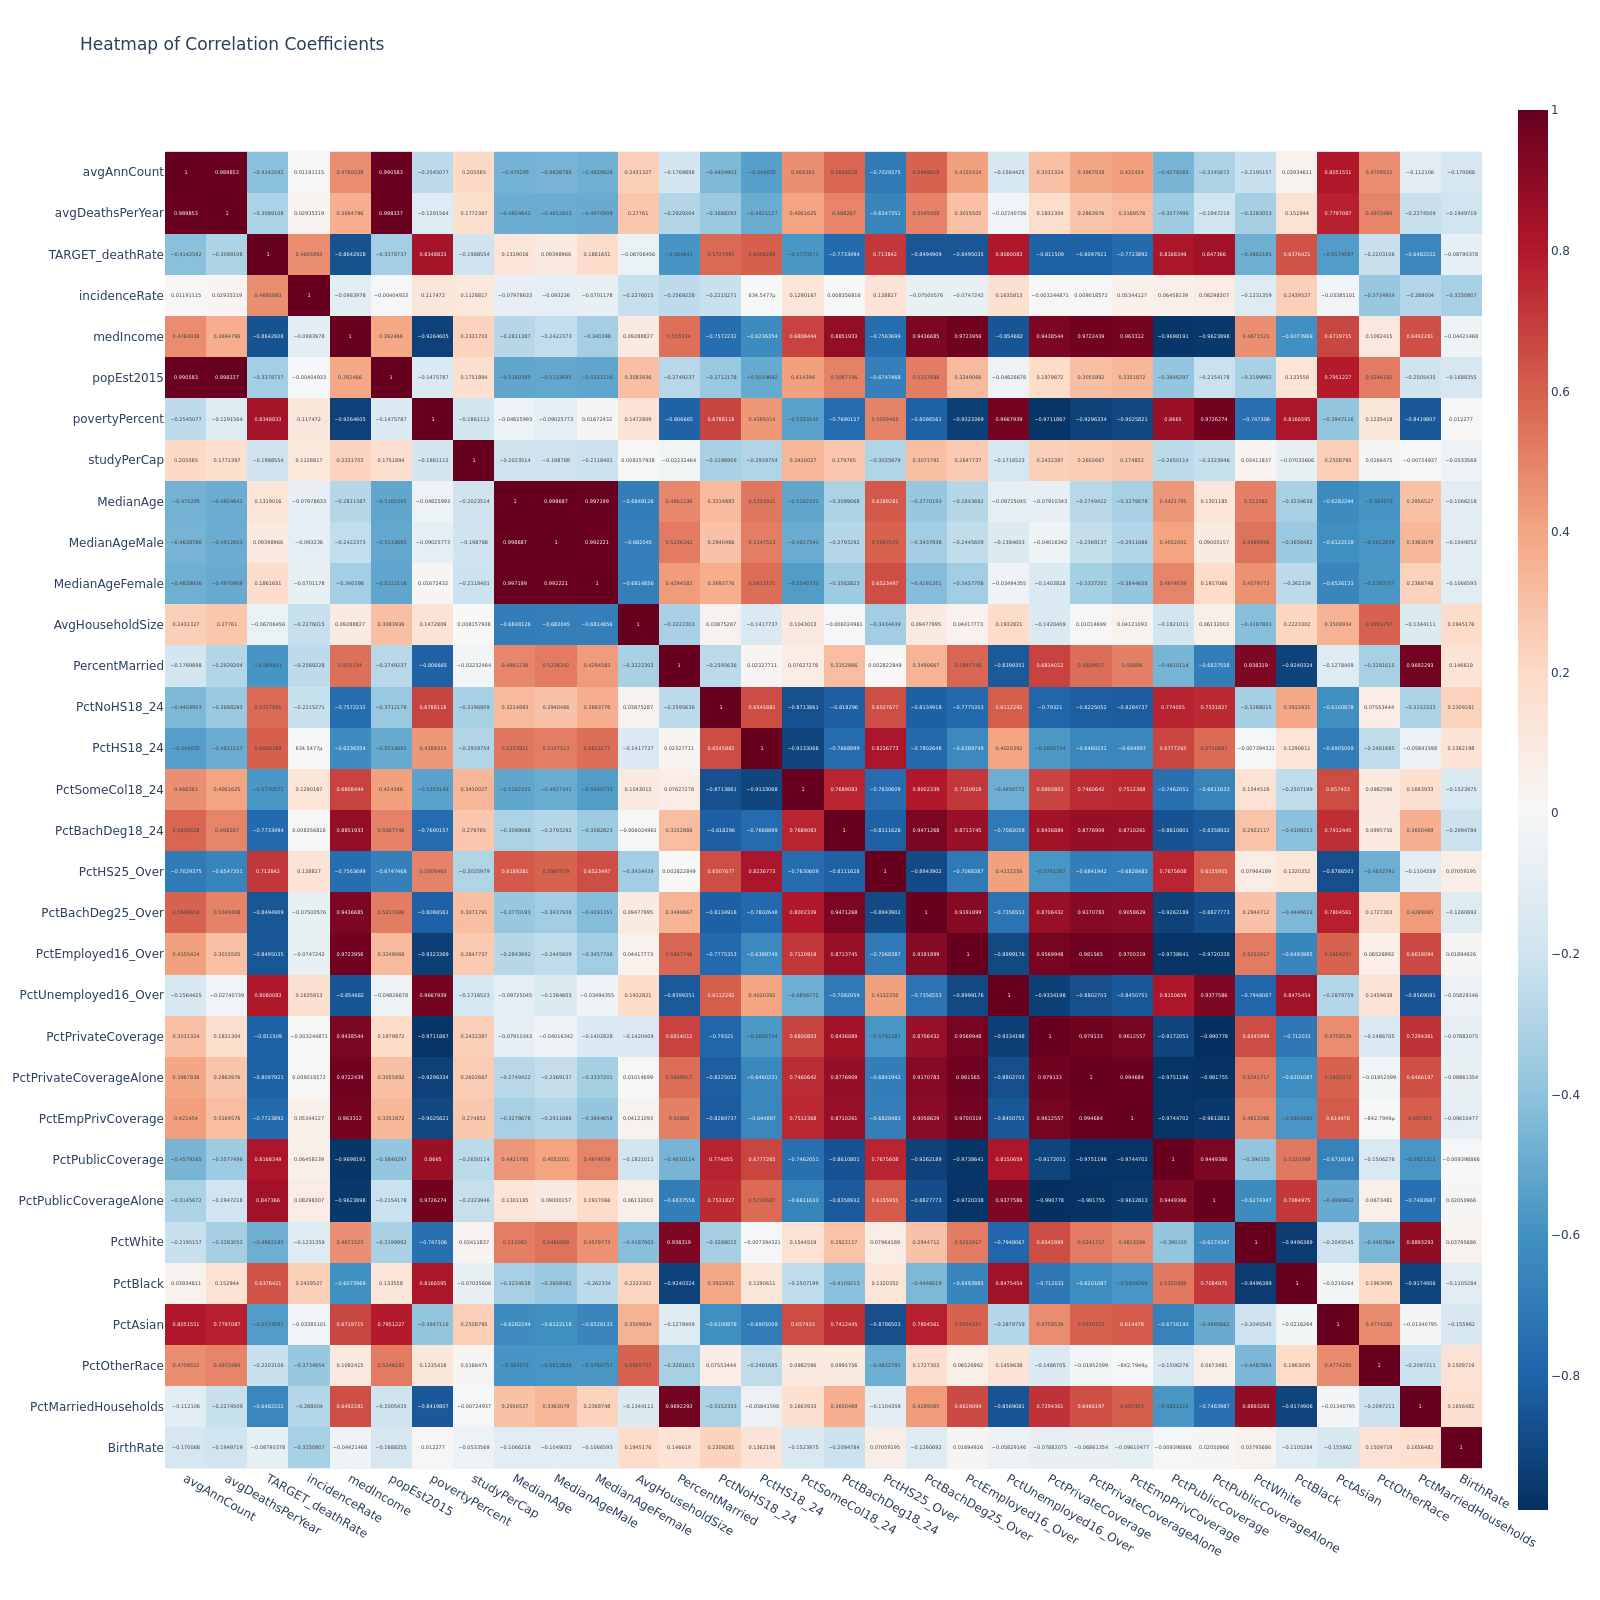

In [6]:
corr_heatmap(df.corr(numeric_only=True), fig_type="png")

In [7]:
def plot_barplot_corr_with_target(df, target='TARGET_deathRate'):
    corr = df.corr(numeric_only=True)[target].drop(target).sort_values()
    plt.figure(figsize=(8, 12))
    sns.barplot(x=corr.values, y=corr.index, palette='RdBu_r')
    plt.title(f'Correlation Coefficients from {target}')
    plt.xlabel('Correlation Coefficients')
    plt.ylabel('Feature')
    plt.show()

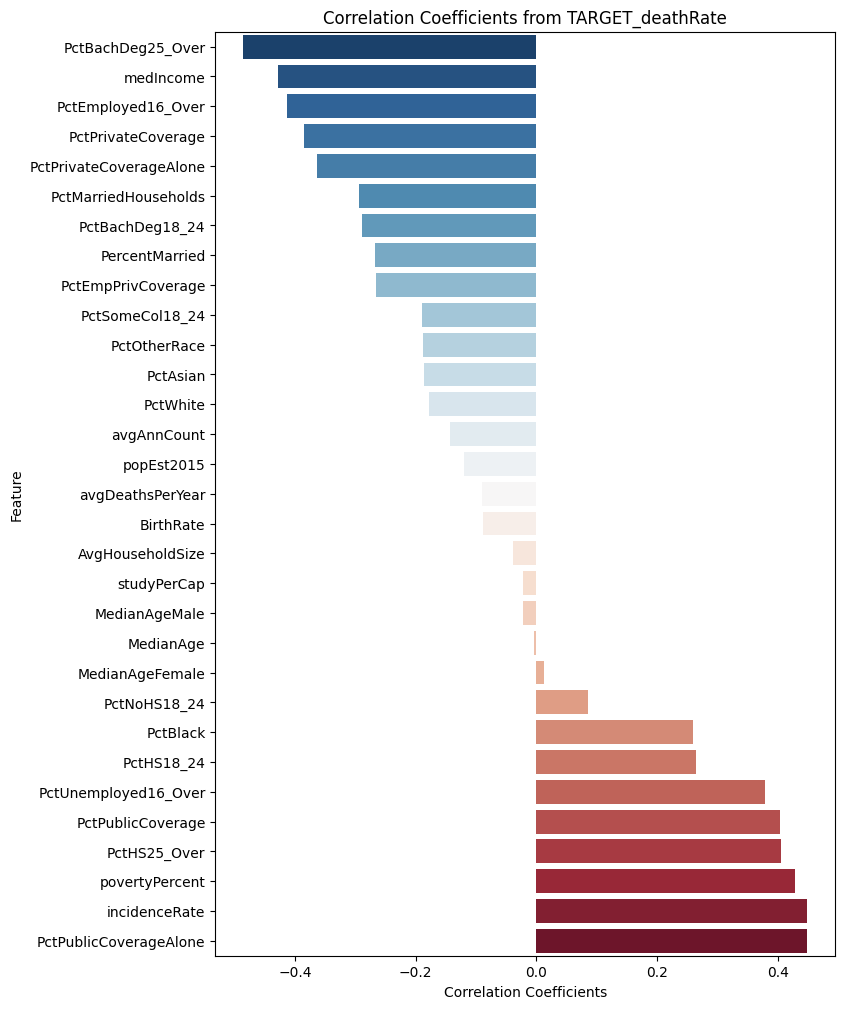

In [8]:
plot_barplot_corr_with_target(df)

# Feature Selection
- avgAnnCount: Mean number of reported cases of cancer diagnosed annually
    - The diagnosis could demonstrate people having a minimal medical treatment.
- incidenceRate: Mean per capita (100,000) cancer diagnoses
    - The diagnosis could demonstrate people having a minimal medical treatment.
- PctPrivateCoverage: Percent of county residents with private health coverage 
    - People that has private health insurance can have a better medical treatment.
- PctPublicCoverage: Percent of county residents with government-provided health coverage 
    - An urge of public health system usage could be a indicative of less people can afford a private health coverage.
- PctBachDeg25_Over: Percent of county residents ages 25 and over highest education attained: bachelor’s degree 
	- Higher education can be an indicative of more income.
- PercentMarried: Percent of county residents who are married 
	- Residents who are married can indicate two incomes in the family, possibly affording the private coverage.
- binnedInc: Median income per capita binned by decile
	- what would I do with this column? Discrete?
- povertyPercent: Percent of populace in poverty
    - Less chance of getting any treatment
- medianIncome: Median income per county
    - Higher median income can be an indicative of less inequality 
- MedianAge: Median age of female county residents 
	- An elderly population may indicate difficulty in facing more severe cancer
- PctWhite
    - Only inputted to help the model to review the social inequality context. Still don't know if it shouldn't be included.
- PctBlack
    - Only inputted to help the model to review the social inequality context. Still don't know if it shouldn't be included.
- PctAsian
    - Only inputted to help the model to review the social inequality context. Still don't know if it shouldn't be included.
- PctOtherRace
    - Only inputted to help the model to review the social inequality context. Still don't know if it shouldn't be included.
- avgDeathsPerYear
    - Number of reported mortalities due to cancer to "adjust" the estimation
- popEst2015
    - Estimate population to "adjust" the estimation

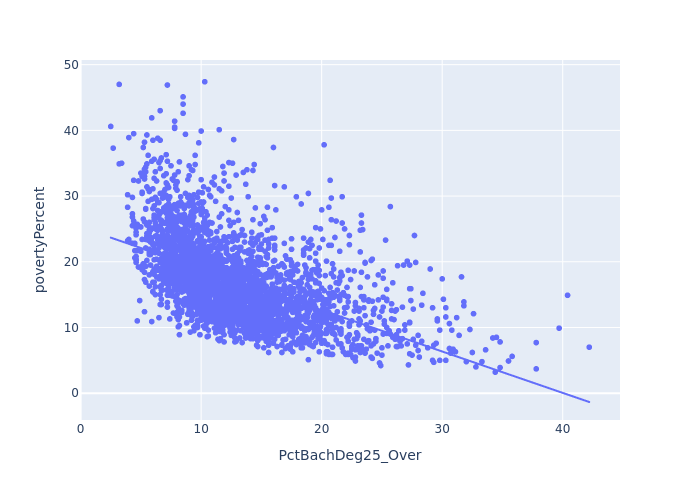

In [9]:
px.scatter(df, x='PctBachDeg25_Over', y='povertyPercent', trendline='ols').show("png")

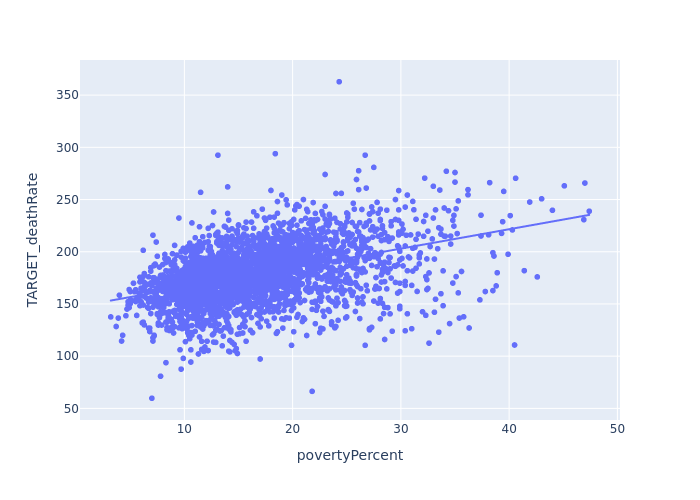

In [10]:
px.scatter(df, x='povertyPercent', y='TARGET_deathRate', trendline='ols').show("png")

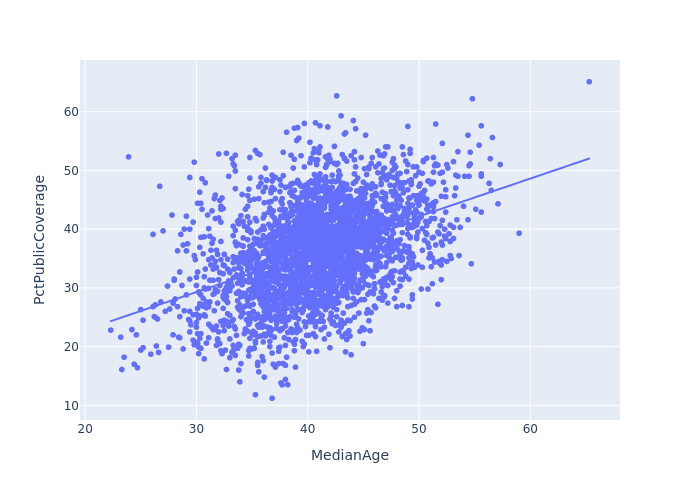

In [11]:
px.scatter(df, x='MedianAge', y='PctPublicCoverage', trendline='ols').show("png")

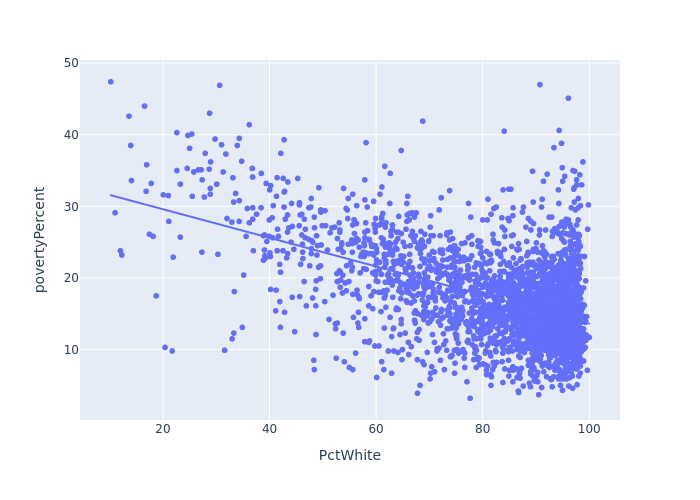

In [12]:
px.scatter(df, x='PctWhite', y='povertyPercent', trendline='ols').show("png")

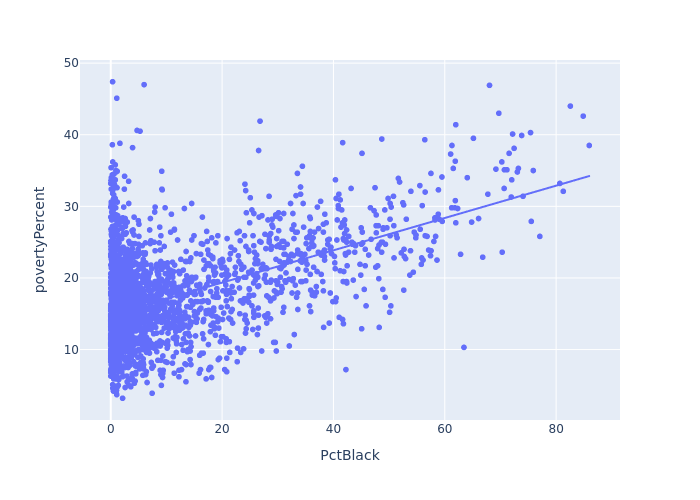

In [13]:
px.scatter(df, x='PctBlack', y='povertyPercent', trendline='ols').show("png")

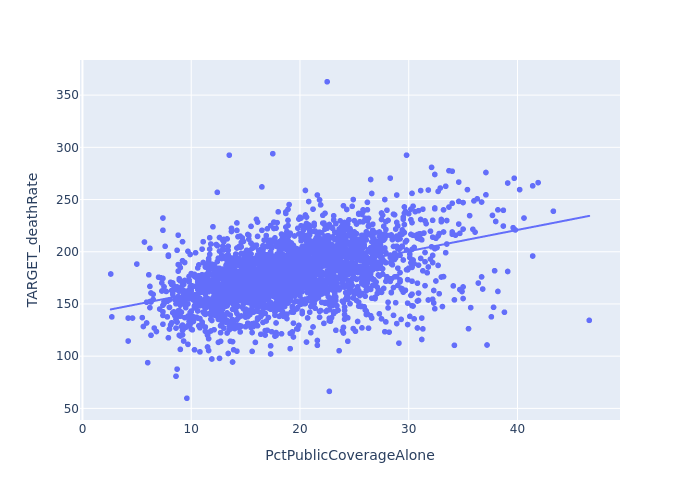

In [14]:
px.scatter(df, x='PctPublicCoverageAlone', y='TARGET_deathRate', trendline='ols').show("png")

In [15]:
features_in = [
"avgAnnCount",
"PctPrivateCoverage",
"PctPublicCoverage",
"PctBachDeg25_Over",
"PercentMarried",
"incidenceRate",
"povertyPercent",
"MedianAge",
"medIncome",
"PctWhite",
"PctBlack",
"PctAsian",
"PctOtherRace",
"avgDeathsPerYear",
"popEst2015",
] #+ df.columns[df.columns.str.startswith("binnedInc_")].tolist()

In [16]:
features_out = df.columns[~(df.columns.isin(features_in)) & (df.columns != 'TARGET_deathRate')].tolist()

In [17]:
features_out

['studyPerCap',
 'binnedInc',
 'MedianAgeMale',
 'MedianAgeFemale',
 'Geography',
 'AvgHouseholdSize',
 'PctNoHS18_24',
 'PctHS18_24',
 'PctSomeCol18_24',
 'PctBachDeg18_24',
 'PctHS25_Over',
 'PctEmployed16_Over',
 'PctUnemployed16_Over',
 'PctPrivateCoverageAlone',
 'PctEmpPrivCoverage',
 'PctPublicCoverageAlone',
 'PctMarriedHouseholds',
 'BirthRate']

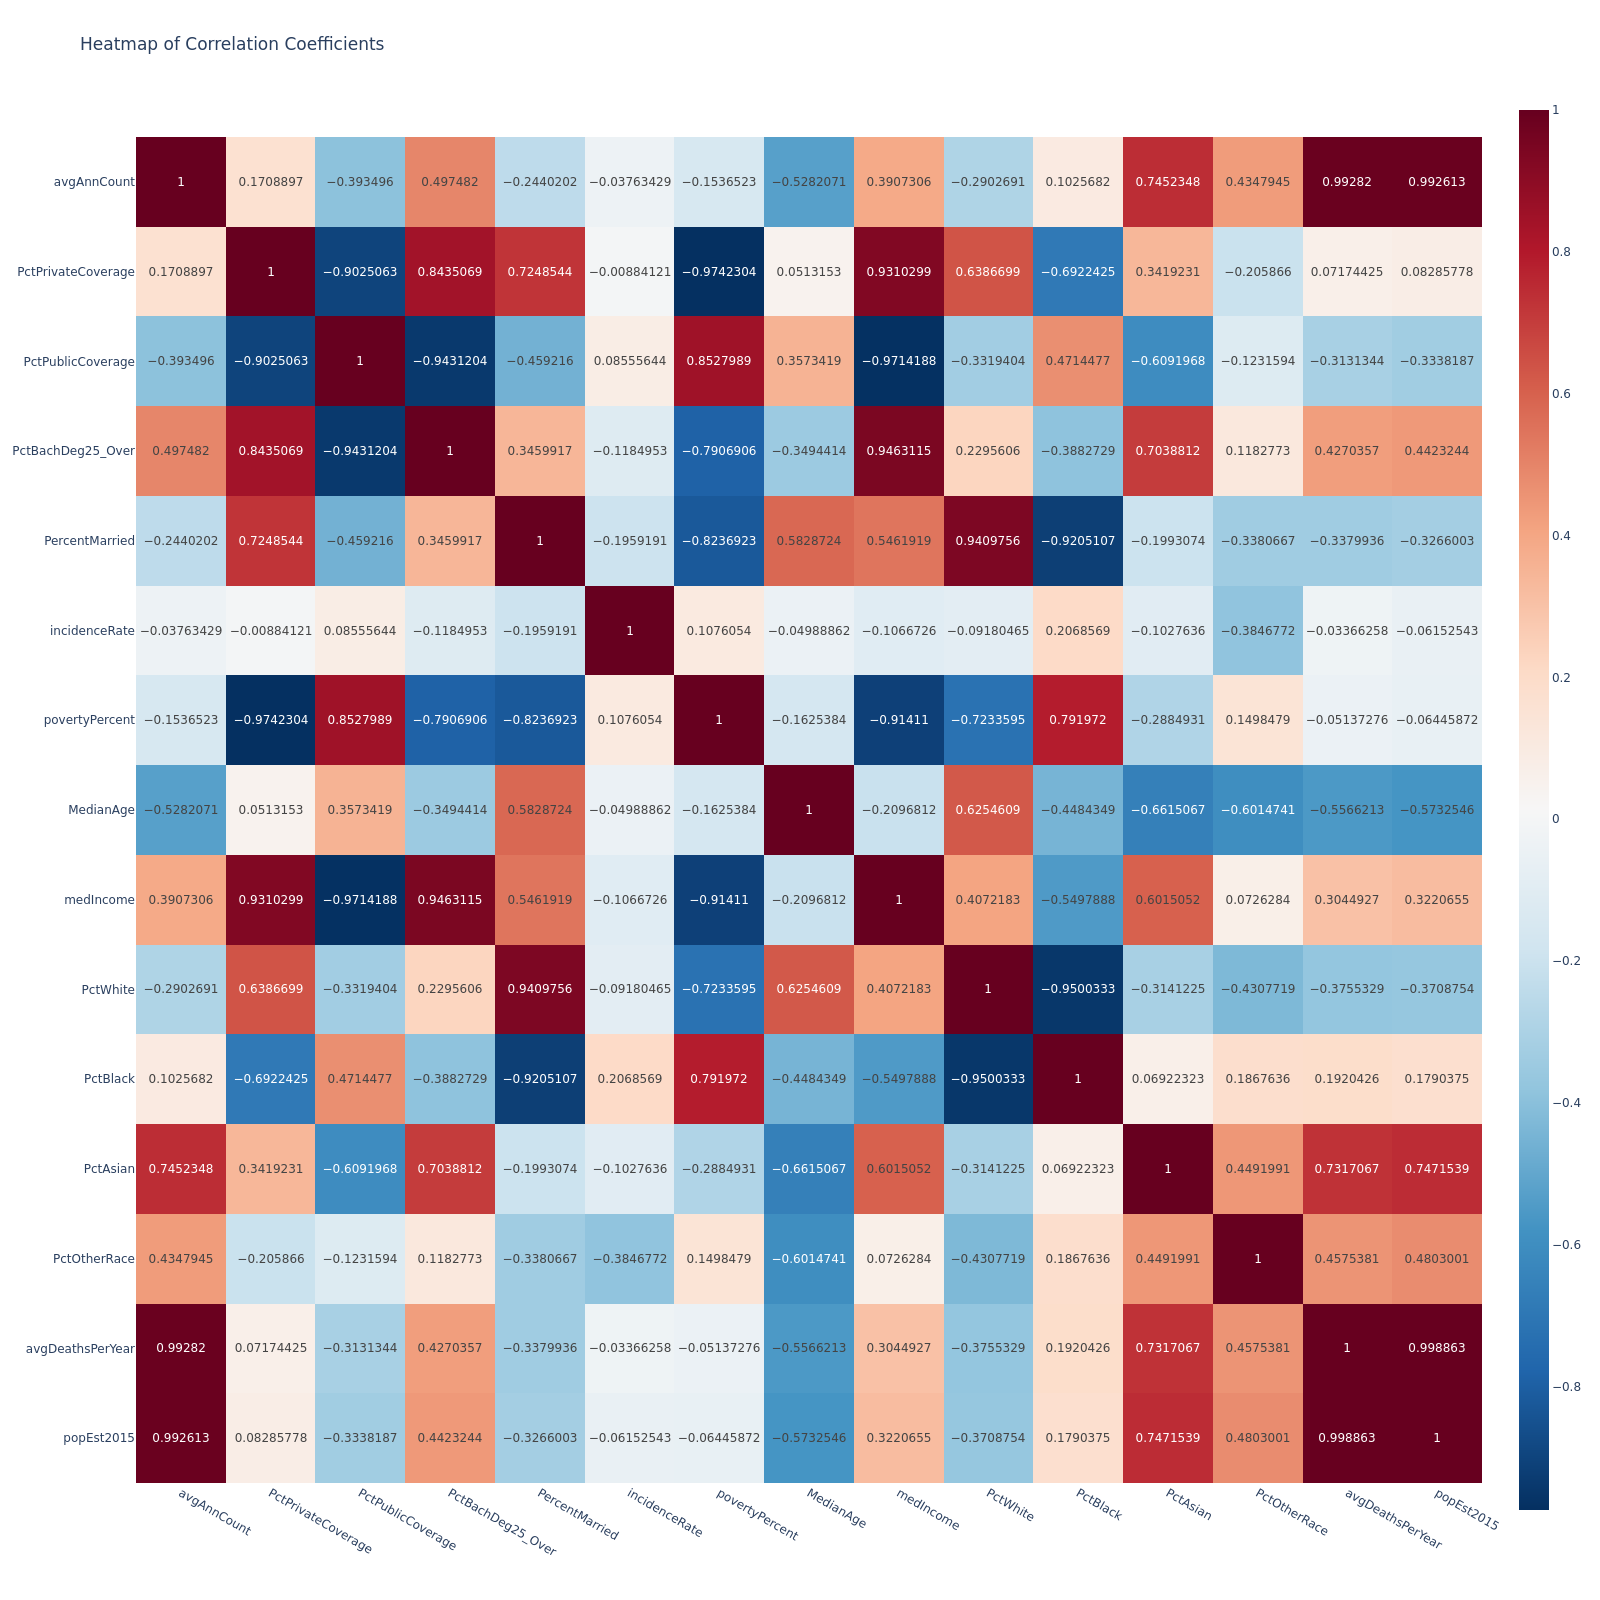

In [18]:
corr_heatmap(df[features_in].corr(numeric_only=True), fig_type="png")

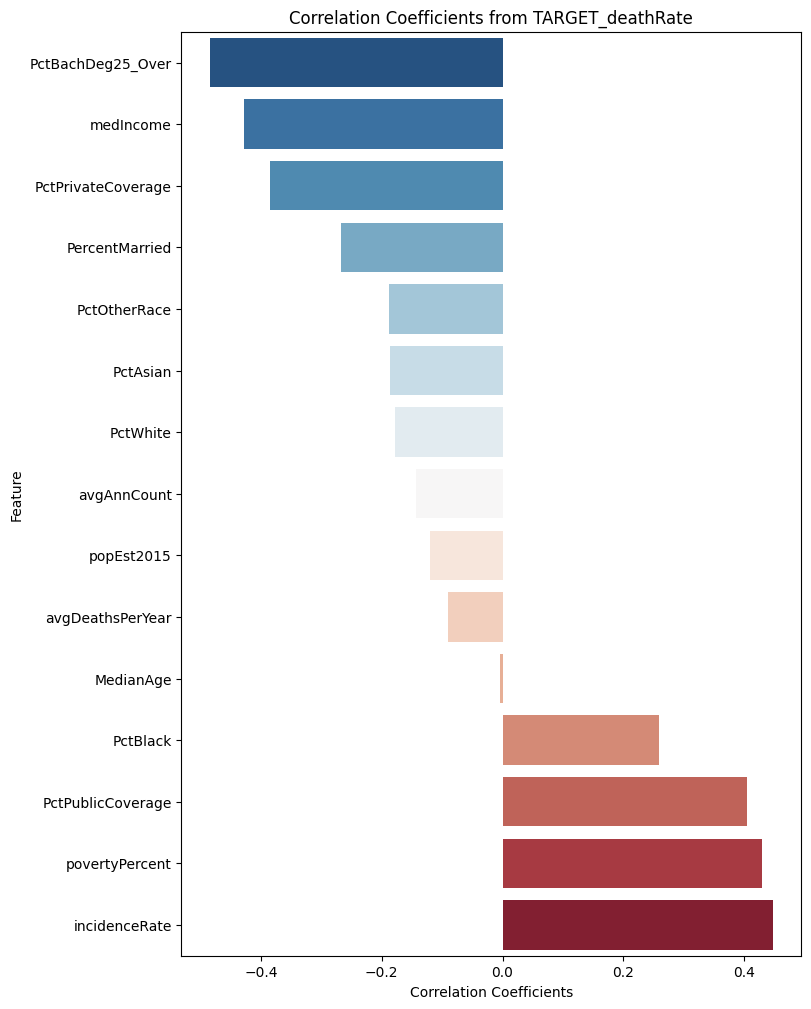

In [19]:
plot_barplot_corr_with_target(df[features_in + ['TARGET_deathRate']])

# Modeling

In [20]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

In [21]:
model = LinearRegression()

In [22]:
model.fit(df_train[features_in], df_train['TARGET_deathRate'])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [23]:
y_pred = model.predict(df_test[features_in])
y_test = df_test['TARGET_deathRate']

## Testing Homoscedasticity

<Axes.ArtistList of 2 lines>

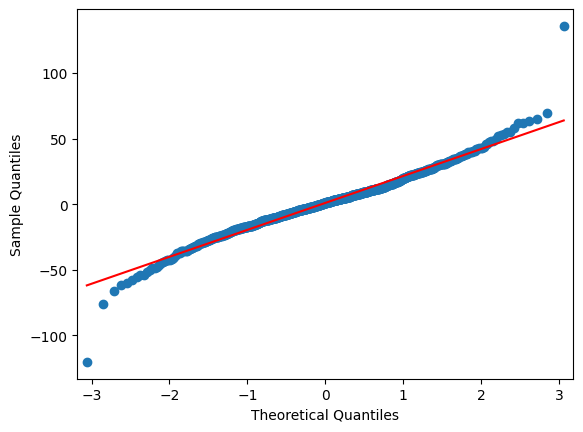

In [24]:
residuals = y_test - y_pred
qqplot(residuals, line='s').gca().lines

In [25]:
# Goldfeld-Quandt test
gq_test = het_goldfeldquandt(residuals, df_test[features_in])
print("Goldfeld-Quandt test:")
print(f"F-stat: {gq_test[0]}, p-value: {gq_test[1]}\n")


Goldfeld-Quandt test:
F-stat: 1.0459806611960663, p-value: 0.319131166970645



In [26]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse, r2

(422.8313911655318, 0.468741349980338)

## Testing VIF & Tolerance

In [27]:
def vif_rank(data):
    if 1 < data < 5:
        return "Low"
    elif 5 <= data < 15:
        return "Moderate"
    elif 15 <= data < 20:
        return "High"
    elif 20 <= data < 30:
        return "Very High"
    return "Extreme"

In [28]:
def generate_vif_dataframe(df, features):
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i) for i in range(df[features].shape[1])]
    vif_data["Tolerance"] = 1 / vif_data["VIF"]
    vif_data["VIF Rank"] = vif_data["VIF"].apply(vif_rank)
    return vif_data

In [29]:
def filtering_features_based_on_vif(X: np.ndarray, threshold=15.0, verbose=False):
    """
    Filter features based on Variance Inflation Factor (VIF).
    Features with VIF above the threshold are removed iteratively."""

    if not isinstance(threshold, (int, float)):
        raise ValueError("Threshold must be a numeric value.")
    if not isinstance(verbose, bool):
        raise ValueError("Verbose must be a boolean value.")
    if X.size == 0:
        raise ValueError("Input X cannot be empty.")
    if X.shape[0] < 2:
        raise ValueError("Input X must have at least two samples.")
    if X.shape[1] < 2:
        raise ValueError("Input X must have at least two features.")

    X = np.asanyarray(X)
    features = np.ones(X.shape[1], dtype=bool)
    for _ in range(features.shape[0]):
        vif = np.zeros(features.shape[0])
        mask = np.where(features)
        vif[mask] = [variance_inflation_factor(X[:, features], i) for i in range(X[:, features].shape[1])]
        max_vif = max(vif)
        idx_max_vif = np.argmax(vif)
        if max_vif >= threshold:
            if verbose:
                print(f"Index of feature with max VIF: {idx_max_vif}")
                print(f"Removing feature with VIF: {max_vif}")
            features[idx_max_vif] = False
            continue
        else:
            break
    return features

In [30]:
def vif_with_target(df, features, target='povertyPercent'):
    vif_results = []
    for feat in features:
        if feat == target:
            continue
        X_pair = df[[target, feat]].dropna()
        vif = [variance_inflation_factor(X_pair.values, i) for i in range(X_pair.shape[1])]
        vif_results.append({'feature': feat, f'VIF_{target}': vif[1]})
    return pd.DataFrame(vif_results).sort_values(by=f'VIF_{target}', ascending=False)

In [31]:
generate_vif_dataframe(df, features_in)

,feature,VIF,Tolerance,VIF Rank
0,avgAnnCount,11.031324,0.090651,Moderate
1,PctPrivateCoverage,164.189517,0.006091,Extreme
2,PctPublicCoverage,123.452930,0.008100,Extreme
3,PctBachDeg25_Over,17.759269,0.056309,High
4,PercentMarried,147.105695,0.006798,Extreme
5,incidenceRate,77.944624,0.012830,Extreme
6,povertyPercent,31.657576,0.031588,Extreme
7,MedianAge,193.159120,0.005177,Extreme
8,medIncome,68.011014,0.014704,Extreme
9,PctWhite,165.040742,0.006059,Extreme


In [32]:
mask_features = filtering_features_based_on_vif(df_test[features_in],  threshold=20.0, verbose=True)

Index of feature with max VIF: 7
Removing feature with VIF: 179.77848453846232
Index of feature with max VIF: 1
Removing feature with VIF: 156.45320041287732
Index of feature with max VIF: 4
Removing feature with VIF: 114.0412147224203
Index of feature with max VIF: 9
Removing feature with VIF: 71.4996187200017
Index of feature with max VIF: 13
Removing feature with VIF: 50.894858936822615
Index of feature with max VIF: 5
Removing feature with VIF: 48.72008033949938
Index of feature with max VIF: 2
Removing feature with VIF: 33.12650706810445


In [33]:
filtered_features = [feature for feature, choosen in zip(features_in, mask_features) if choosen]
generate_vif_dataframe(df_test, filtered_features)

,feature,VIF,Tolerance,VIF Rank
0,avgAnnCount,12.726466,0.078576,Moderate
1,PctBachDeg25_Over,15.317058,0.065287,High
2,povertyPercent,5.358000,0.186637,Moderate
3,medIncome,18.460124,0.054171,High
4,PctBlack,1.893781,0.528044,Low
5,PctAsian,1.835499,0.544811,Low
6,PctOtherRace,1.406074,0.711200,Low
7,popEst2015,12.140916,0.082366,Moderate


In [34]:
vif_with_target(df_test, filtered_features, target='povertyPercent')

,feature,VIF_povertyPercent
2,medIncome,3.440419
1,PctBachDeg25_Over,2.784712
3,PctBlack,1.765746
5,PctOtherRace,1.258671
4,PctAsian,1.135877
0,avgAnnCount,1.082022
6,popEst2015,1.047709


### Feature Importance

In [35]:
def standardize_coefficients(model: LinearRegression, df_train: pd.DataFrame):
    """
    Standardize the coefficients of the model based on the standard deviation of the features and target.
    """
    std_coef = np.zeros(len(model.coef_))
    for i in range(len(model.feature_names_in_)):
        std_coef[i] = model.coef_[i] * df_train[model.feature_names_in_[i]].std() / df_train['TARGET_deathRate'].std()
    return std_coef

In [36]:
standardize_coefficients(model, df_train)

array([-0.21944617, -0.13600125,  0.01909998, -0.33080481, -0.03828784,
        0.40601019,  0.10954138, -0.0394726 ,  0.00869306, -0.04225385,
       -0.03711937,  0.03474138, -0.1493404 ,  0.38301067, -0.18046279])

In [37]:
model.feature_importance_ = standardize_coefficients(model, df_train)

In [38]:
feature_importance = pd.DataFrame({
    'feature': model.feature_names_in_,
    'std_coef': model.feature_importance_
}).sort_values(by='std_coef', ascending=False).reset_index(drop=True)

In [39]:
feature_importance

,feature,std_coef
0,incidenceRate,0.406010
1,avgDeathsPerYear,0.383011
2,povertyPercent,0.109541
3,PctAsian,0.034741
4,PctPublicCoverage,0.019100
5,medIncome,0.008693
6,PctBlack,-0.037119
7,PercentMarried,-0.038288
8,MedianAge,-0.039473
9,PctWhite,-0.042254


## Testing Results Filtering Based On VIF

In [40]:
filtered_features

['avgAnnCount',
 'PctBachDeg25_Over',
 'povertyPercent',
 'medIncome',
 'PctBlack',
 'PctAsian',
 'PctOtherRace',
 'popEst2015']

In [41]:
X = sm.add_constant(df_train[filtered_features]) # add intercept
y = df_train["TARGET_deathRate"]
model_sm = sm.OLS(y, X).fit()
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       TARGET_deathRate   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     132.8
Date:                Thu, 17 Jul 2025   Prob (F-statistic):          1.43e-180
Time:                        09:16:15   Log-Likelihood:                -9561.2
No. Observations:                2111   AIC:                         1.914e+04
Df Residuals:                    2102   BIC:                         1.919e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               187.1587      5.766     32.461      0.000     175.852     198.465
avgAnnCount          -0.0006      0.001     -0.626      0.532      -0.002       0.001
PctBachDeg25_Over    -2.0531      0.132    -15.557      0.000      -2.312      -1.794
povertyPercent        1.0155      0.152      6.663      0.000       0.717       1.314
medIncome          5.939e-05   8.72e-05      0.681      0.496      -0.000       0.000
PctBlack              0.1038      0.042      2.498      0.013       0.022       0.185
PctAsian              0.3663      0.244      1.503      0.133      -0.112       0.844
PctOtherRace         -1.7309      0.153    -11.291      0.000      -2.032      -1.430
popEst2015         8.847e-06   4.53e-06      1.951      0.051   -4.38e-08    1.77e-05
==============================================================================
Omnibus:                      107.905   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              311.503
Skew:                          -0.218   Prob(JB):                     2.28e-68
Kurtosis:                       4.831   Cond. No.                     3.41e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.41e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Multiple Linear Regression: Dividing by binnedInc

In [42]:
def generate_regression_models_by_binned_inc(df, features,target='TARGET_deathRate', binned_col='binnedInc'):
    """
    Create a multiple linear regression model for each bin of the binned income column.
    """
    models = {}
    for bin_value in df[binned_col].unique():
        df_bin = df[df[binned_col] == bin_value]
        model = LinearRegression()
        models[bin_value] = model.fit(df_bin[features], df_bin[target])
    return models


In [43]:
multi_models = generate_regression_models_by_binned_inc(df_train, features_in)

In [44]:
def evaluate_regression_models(models, df_test, features, target='TARGET_deathRate', binned_col='binnedInc'):
    """
    Evaluate multiple regression models on the test set.
    """
    results = {}
    for bin_value in models:
        df_bin = df_test[df_test[binned_col] == bin_value]
        y_pred = models[bin_value].predict(df_bin[features])
        y_test = df_bin[target]
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[bin_value] = {'mse': mse, 'r2': r2}
    return pd.DataFrame(results).T

In [47]:
evaluate_regression_models(multi_models, df_test, features_in)

,mse,r2
"(54545.6, 61494.5]",416.573138,-0.084669
"[22640, 34218.1]",448.086709,0.578795
"(42724.4, 45201]",471.804563,0.279485
"(48021.6, 51046.4]",343.361016,0.188114
"(51046.4, 54545.6]",283.161693,0.303111
"(40362.7, 42724.4]",490.457145,0.218970
"(61494.5, 125635]",459.396419,0.302563
"(45201, 48021.6]",706.251063,-0.030037
"(37413.8, 40362.7]",492.317350,0.544392
"(34218.1, 37413.8]",2097.678543,-2.445344


In [48]:
def generate_qqplot_by_binned_inc(models, df_test, features):
    """
    Generate QQ plots for the residuals of each regression model.
    """
    binned_col = 'binnedInc'
    for bin_value in models:
        df_bin = df_test[df_test[binned_col] == bin_value]
        y_pred = models[bin_value].predict(df_bin[features])
        y_test = df_bin['TARGET_deathRate']
        residuals = y_test - y_pred
        qqplot(residuals, line='s').gca().lines
        plt.title(f'QQ Plot for {binned_col} = {bin_value}')
        plt.show()

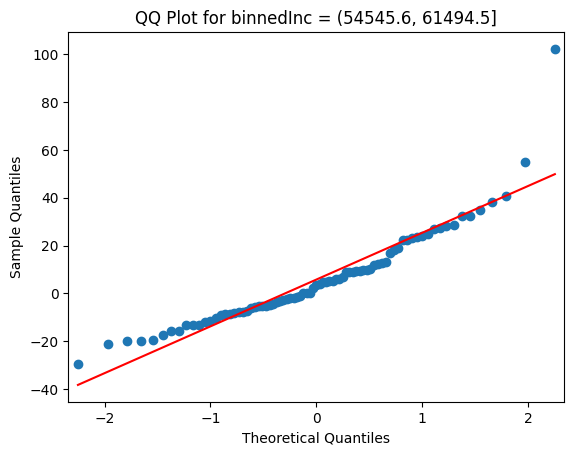

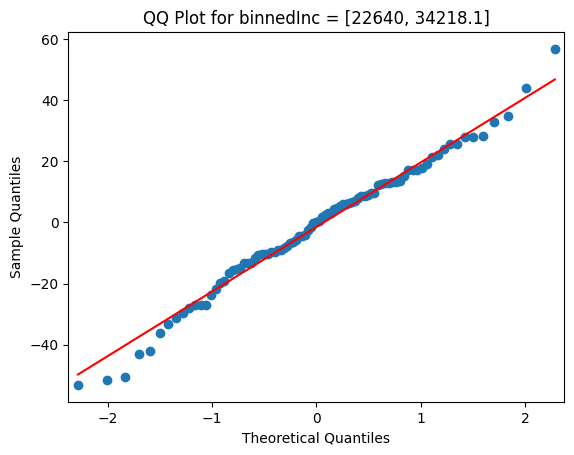

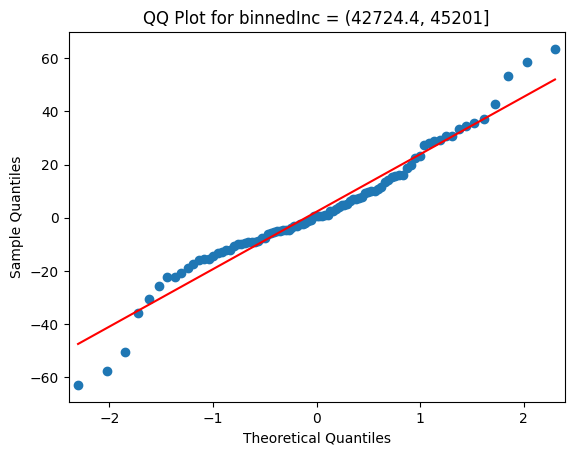

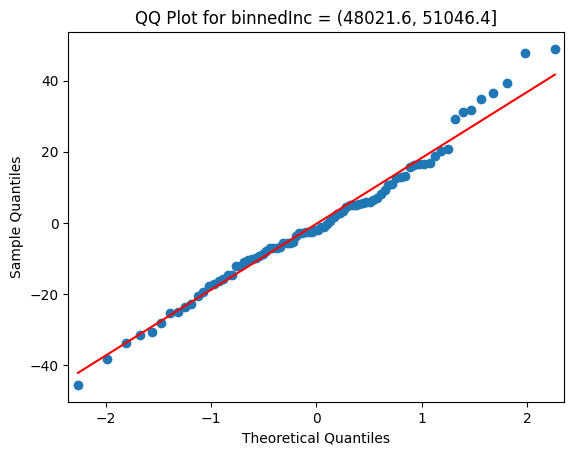

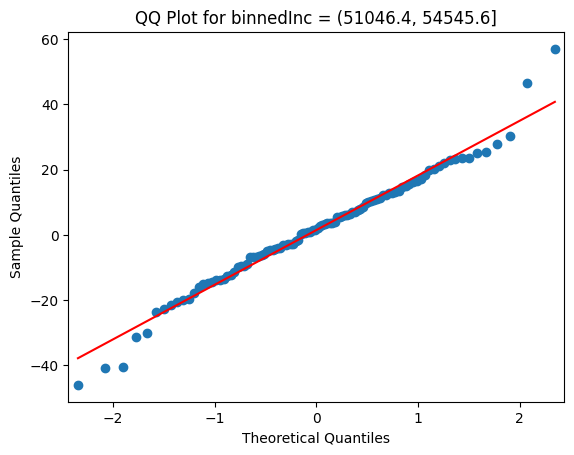

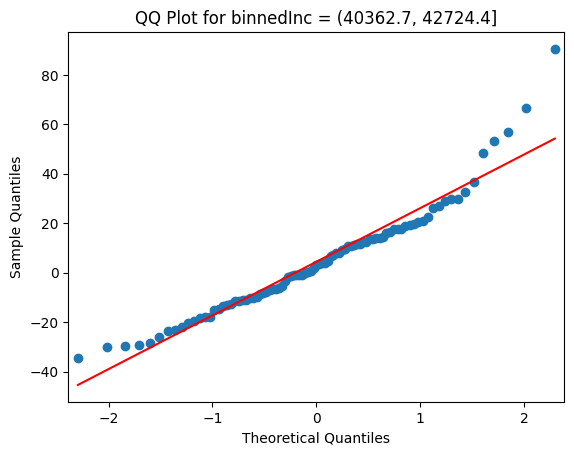

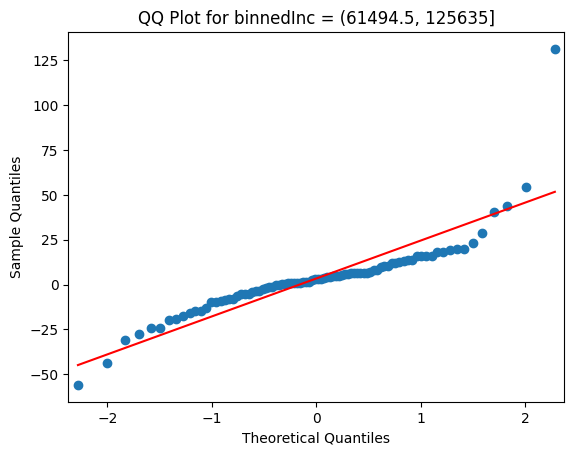

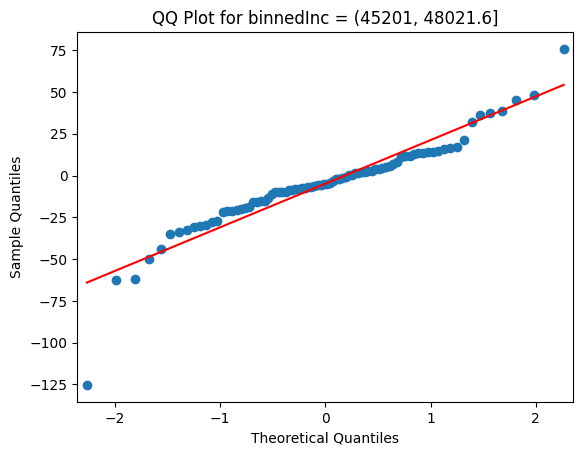

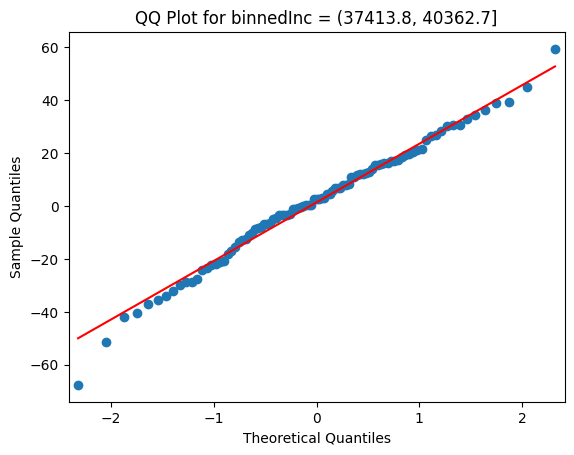

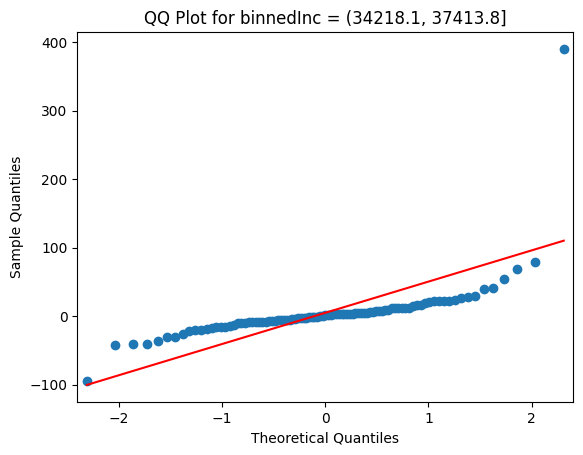

In [49]:
generate_qqplot_by_binned_inc(multi_models, df_test, features_in)

## RandomForestRegressor

Due to multicollinearity, others models should be better in the context

In [50]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1, oob_score=True, max_depth=int(np.ceil(np.log2(len(df_train)) - 1)), min_samples_leaf=5)
rf.fit(df_train[features_in], df_train['TARGET_deathRate'])

,n_estimators,100
,criterion,'squared_error'
,max_depth,11
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [51]:
rf_y_pred = rf.predict(df_test[features_in])
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)
rf_mse, rf_r2

(385.45497129116615, 0.5157022587016349)

In [52]:
feature_importances = pd.DataFrame(
            rf.feature_importances_,
            index=rf.feature_names_in_,
            columns=["importance"],
        ).sort_values("importance", ascending=False)

In [53]:
feature_importances

,importance
PctBachDeg25_Over,0.287906
incidenceRate,0.237233
medIncome,0.094570
PctPrivateCoverage,0.056392
avgDeathsPerYear,0.052317
PctOtherRace,0.037536
PctBlack,0.036544
povertyPercent,0.029247
PctPublicCoverage,0.027550
PercentMarried,0.027082


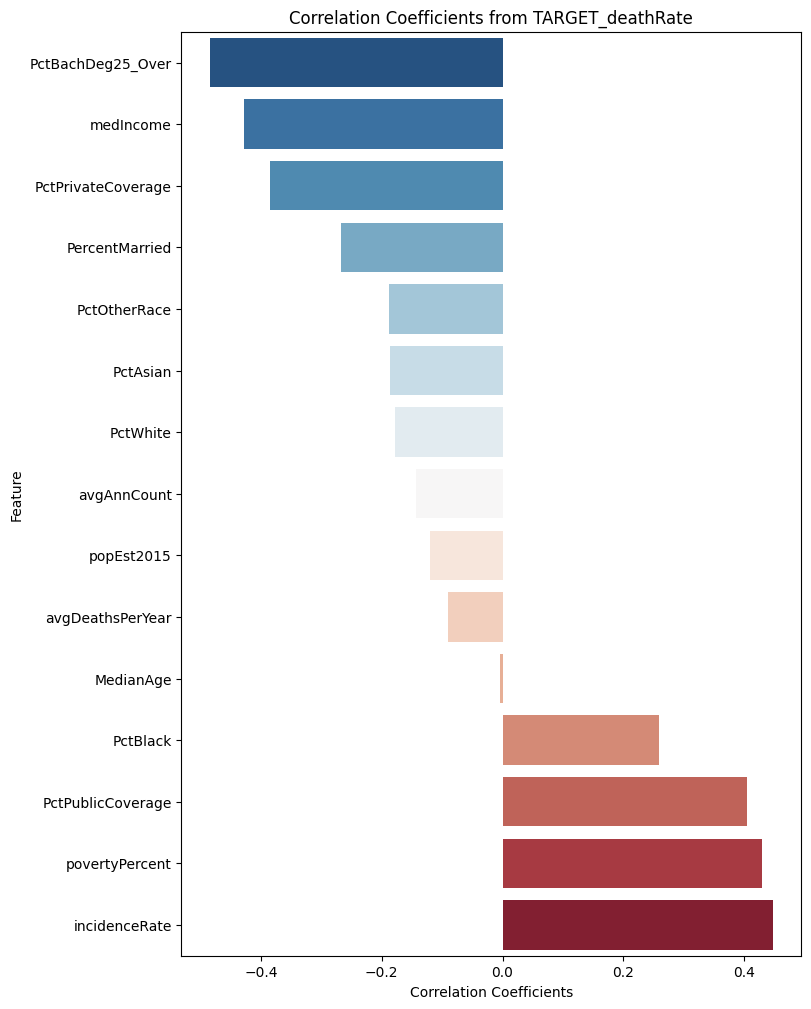

In [54]:
plot_barplot_corr_with_target(df[features_in + ['TARGET_deathRate']])

# Conformal Prediction

In [55]:
reg = ConformalizedRegressor(rf, alpha=0.20)

In [56]:
reg.fit(y=df_train['TARGET_deathRate'], oob=True)

In [57]:
y_pred_intervals = reg.predict_interval(df_test[features_in])
y_pred = reg.predict(df_test[features_in])

In [58]:
reg.evaluate(df_test[features_in], df_test['TARGET_deathRate'])

{'total': 906,
 'alpha': 0.2,
 'coverage_rate': 0.796,
 'interval_width_mean': 43.715,
 'mwis': 69.947,
 'mae': 14.177,
 'mbe': -1.301,
 'mse': 385.455}

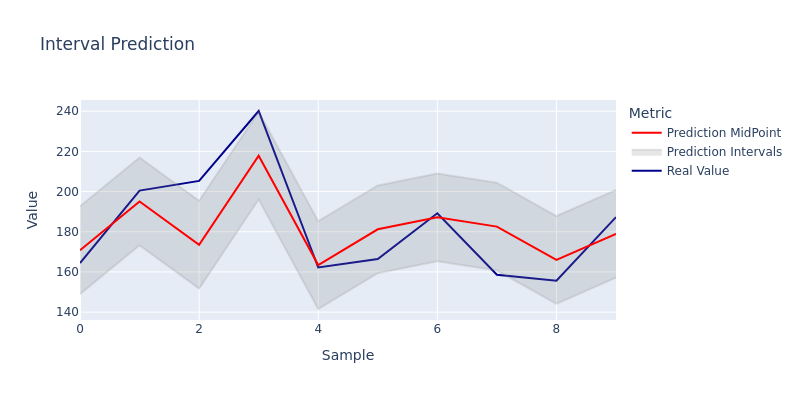

In [59]:
plot_prediction_intervals(y_pred_intervals[:10], y_pred[:10], y_test[:10], fig_type="png")